# import libraries

In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import itertools
import random
import time
import math

# Sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

# Read data

In [18]:
park_data = pd.read_csv("parkinsons.csv")

park_inp = park_data.drop("target", axis=1)
park_tar = park_data["target"]

# Basic data visualisation and scale analysis

### Target visualisation for curiosity

It's interesting to note that the scale varies from 0 to 260. Although as we will see in the target visualisation we only have scores below 

(array([ 249.,  471.,  754.,  984., 1044.,  836.,  591.,  550.,  183.,
         213.]),
 array([ 7.    , 11.7992, 16.5984, 21.3976, 26.1968, 30.996 , 35.7952,
        40.5944, 45.3936, 50.1928, 54.992 ]),
 <BarContainer object of 10 artists>)

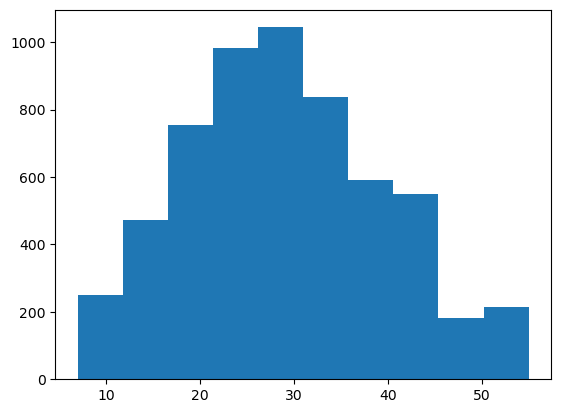

In [19]:
plt.hist(park_tar)
#plt.xlim([0,260])

Min, Max, and Difference values for each column:
                    Min        Max  Difference
age           -3.265580   2.289489    5.555069
sex           -0.682509   1.465182    2.147691
test_time     -1.817446   2.294608    4.112054
Jitter(%)     -0.946657  16.685707   17.632364
Jitter(Abs)   -1.161111  11.160633   12.321744
Jitter:RAP    -0.850693  17.464987   18.315680
Jitter:PPQ5   -0.762982  17.764476   18.527458
Jitter:DDP    -0.851770  17.465979   18.317749
Shimmer       -1.199058   9.081220   10.280278
Shimmer(dB)   -1.237697   7.800931    9.038628
Shimmer:APQ3  -1.174502  10.993835   12.168337
Shimmer:APQ5  -1.092523   8.814745    9.907268
Shimmer:APQ11 -1.250516  12.408608   13.659124
Shimmer:DDA   -1.174245  10.994080   12.168325
NHR           -0.533344  11.998215   12.531559
HNR           -4.665987   3.774533    8.440520
RPDE          -3.866744   4.204980    8.071724
DFA           -1.963436   2.995380    4.958816
PPE           -2.159850   5.597736    7.757586
target     

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

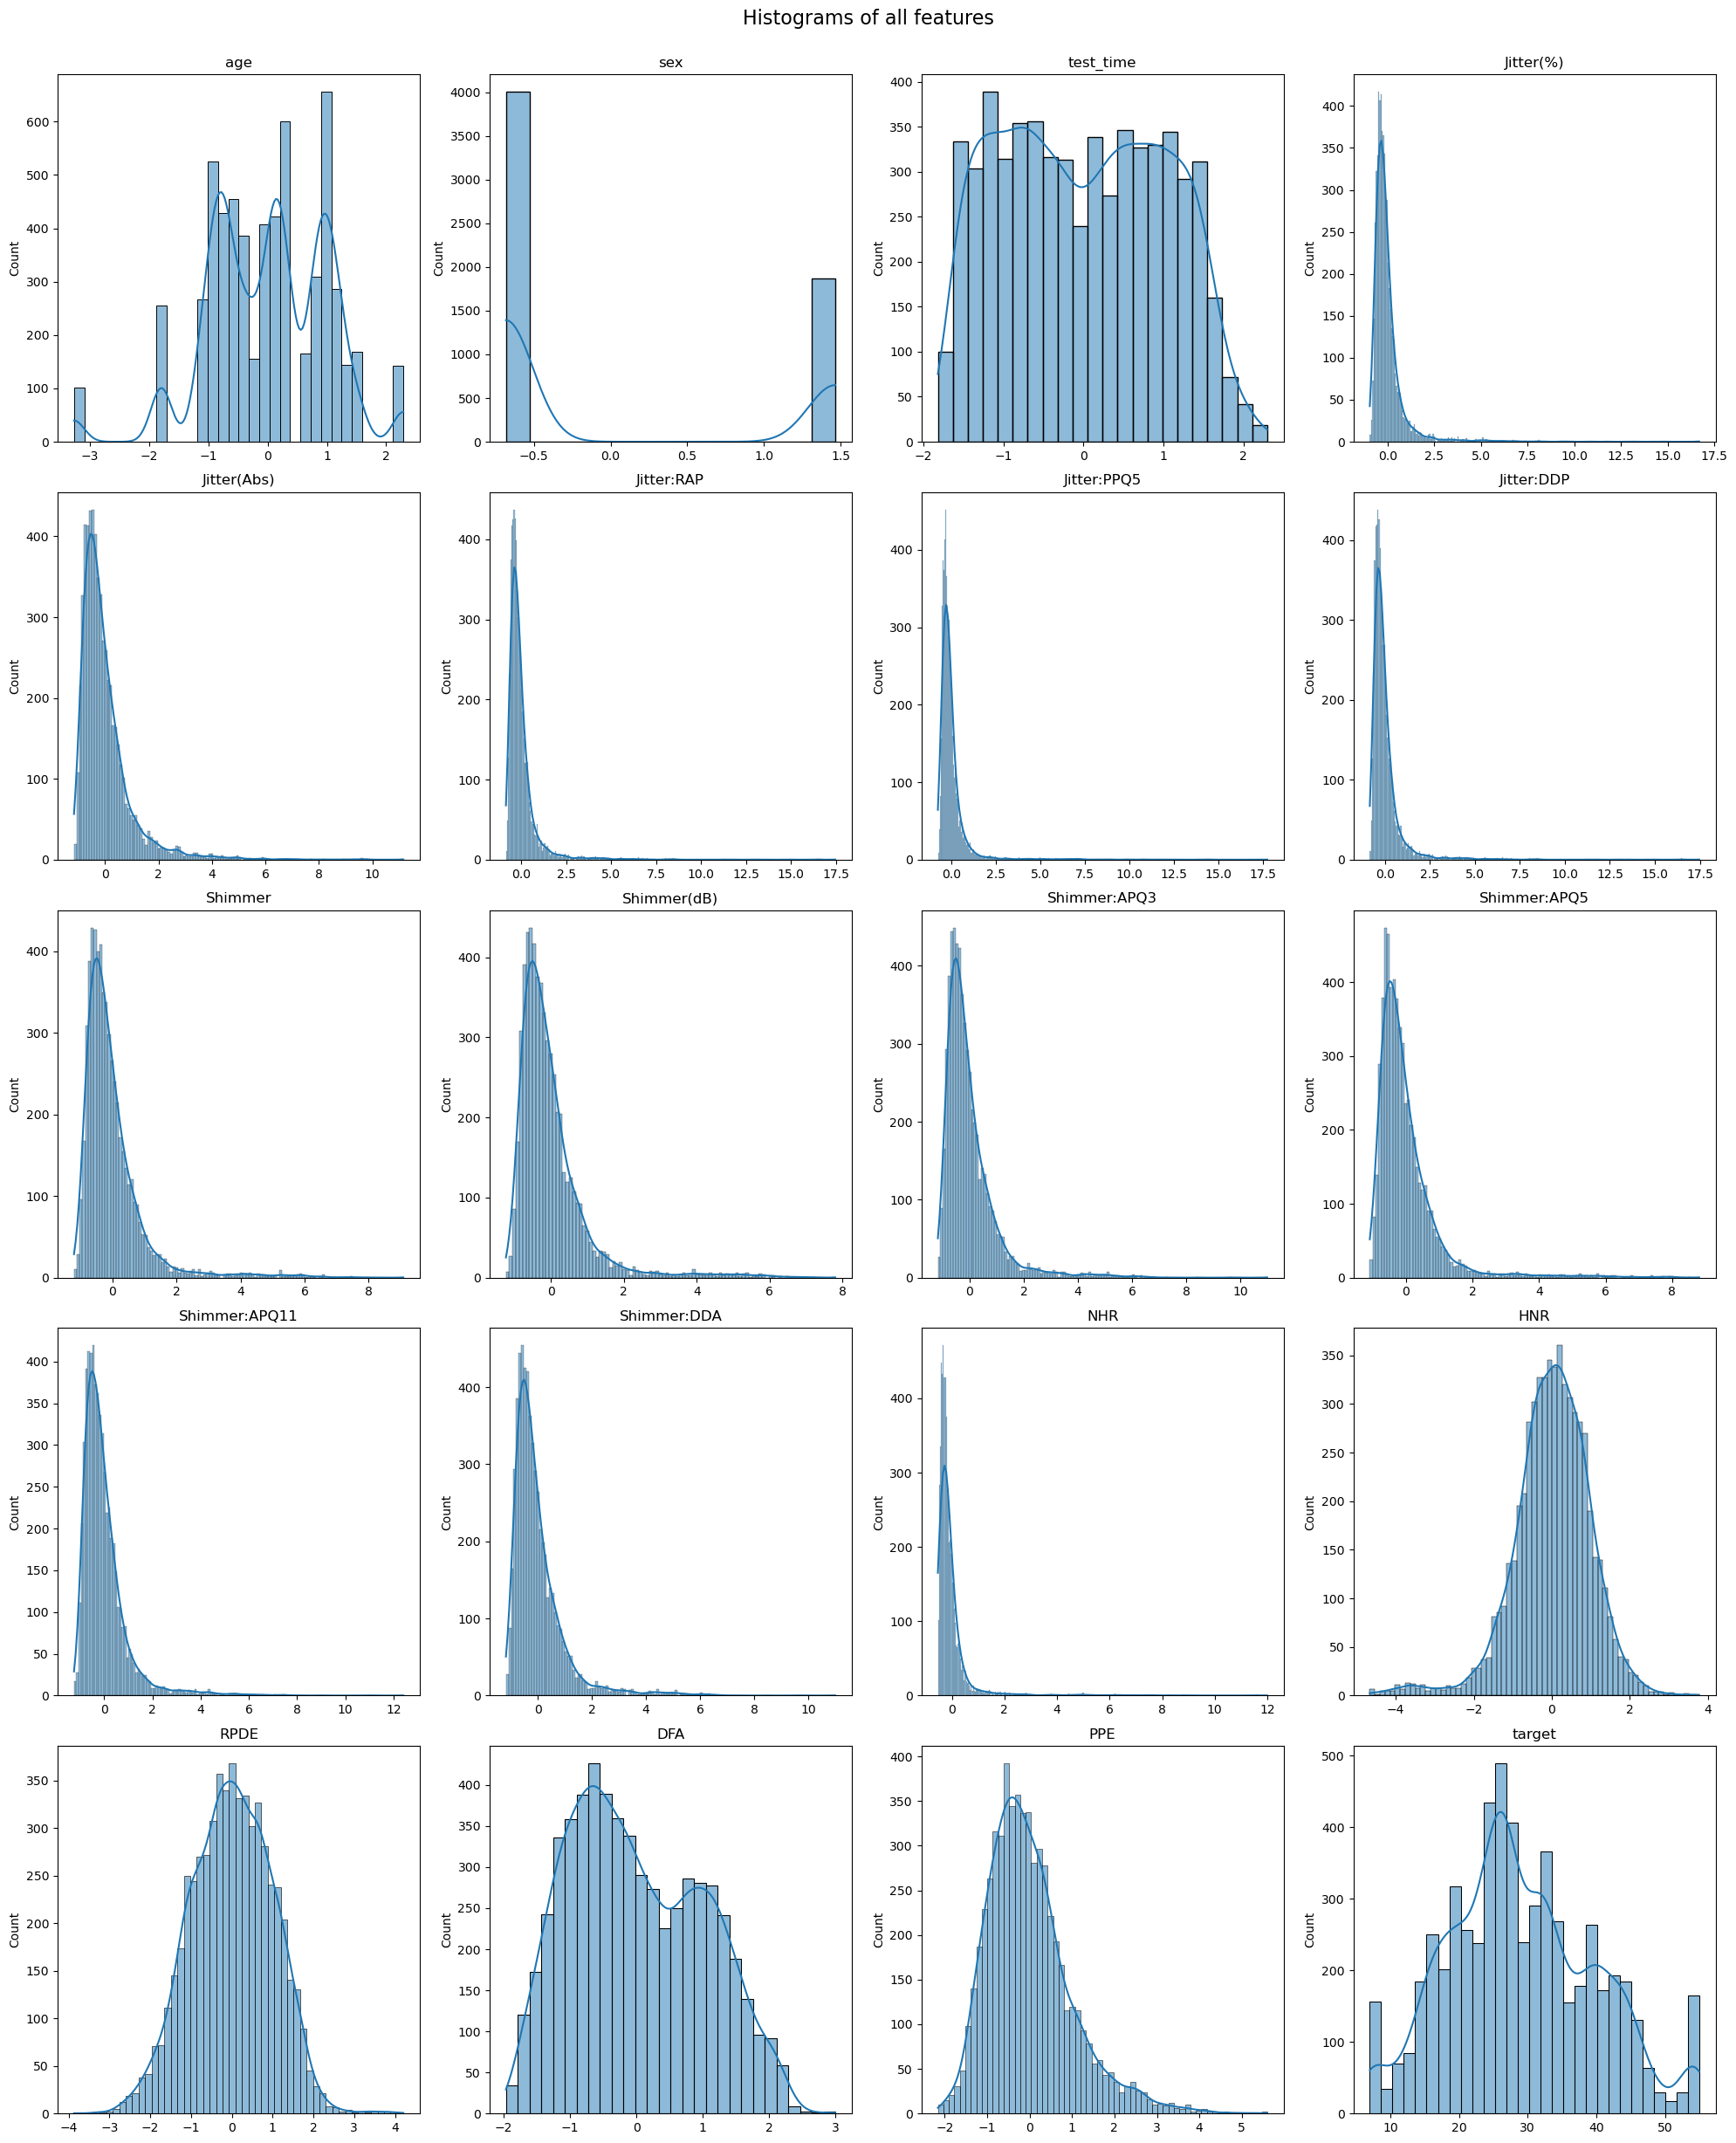

In [20]:
# Assuming park_data is already loaded

# Calculate min, max, and difference for each column
min_values = park_data.min()
max_values = park_data.max()
diff_values = max_values - min_values

# Create a DataFrame with min, max, and difference
summary_df = pd.DataFrame({
    'Min': min_values,
    'Max': max_values,
    'Difference': diff_values
})

# Display the summary
print("Min, Max, and Difference values for each column:")
print(summary_df)

# Create histograms for all columns
fig, axes = plt.subplots(5, 4, figsize=(20, 25))
fig.suptitle("Histograms of all features", fontsize=16)

for i, column in enumerate(park_data.columns):
    row = i // 4
    col = i % 4
    sns.histplot(park_data[column], ax=axes[row, col], kde=True)
    axes[row, col].set_title(column)
    axes[row, col].set_xlabel('')

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

# 5) Model comparison
- Linear regression Model (LR)
- MLP Regressor with 2 hidden layers of 10 neurons each + no activation functions (MLP_NA)
- MLP Regressor with 2 hidden layers of 10 neurons each + ReLU activation functions (MLP_ReLU)



MLP random_state=0
Boxplot of Mean Absolute Error (MAE) for each model

### Data splitting

In [21]:
rand_st = list(range(1,11))

train_test_data = []
for rand in rand_st:
    inp_train_temp, inp_test_temp, tar_train_temp, tar_test_temp =\
    train_test_split(park_inp,park_tar,test_size=0.2,random_state=rand)
    train_test_data.append(
        [inp_train_temp, inp_test_temp, tar_train_temp, tar_test_temp])

Model Definition

In [22]:
# Linear Regression Model
linear_model = LinearRegression()

# MLP Regressor with 2 hidden layers, no activation
mlp_no_activation = MLPRegressor(hidden_layer_sizes=(10, 10),
                                 activation='identity',
                                 random_state=0)

# MLP Regressor with 2 hidden layers, ReLU activation
mlp_relu = MLPRegressor(hidden_layer_sizes=(10, 10),
                        activation='relu',
                        random_state=0)

# List of models
models = [linear_model, mlp_no_activation, mlp_relu]
model_names = ['Linear Regression', 'MLP (No Activation)', 'MLP (ReLU)']

In [23]:
def evaluate_model(model, X_train, y_train, X_test):
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    return model.predict(X_test)

# Perform cross-validation and calculate MAE for each model
mae_scores = []

for model in models:
    mae_score_temp = []
    for run in range(10):
        y_pred = evaluate_model(model, train_test_data[run][0], train_test_data[run][2],
                       train_test_data[run][1])
        mae = mean_absolute_error(train_test_data[run][3], y_pred)
        mae_score_temp.append(mae)  # Negate because sklearn returns negative MAE
    mae_scores.append(mae_score_temp)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_

Plot the results from the training.

Text(0, 0.5, 'MAE')

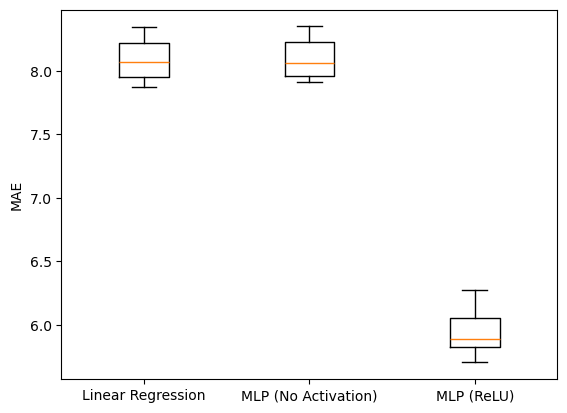

In [24]:
plt.boxplot(mae_scores, labels=model_names)
plt.ylabel("MAE")

# 6)
The results from the MLP_NA and the Linear Regression are very similar, this is because without an activation function the MLP produces only a Linear Regression.
From We can think of the Results that come up from the MLP Like


Z^{[1]} = W^{[1]}X^{[0]} + b^{[1]}

X^{[1]} = Z^{[1]}

Z^{[2]} = W^{[2]}X^{[1]} + b^{[2]}

X^{[2]} = Z^{[2]} = W^{[2]}W^{[1]}X^{[0]} + W^{[2]}b^{[1]} + b^{[2]}

Where the left half could also be represented as W and the right half a general constant 

# 7.
20-80 train-test split random_state = 0

Grid Search of hyperparameters from the model of MultiLayer Perceptron 2 hidden layers 10 neurons each
- (i)   L2 penalty    [0.001,0.01,0.1]
- (ii)  learning rate [0.001,0.01,0.1]
- (iii) batch size    [32,64,128]

# 7)  Normal version

In [25]:
# Split the data
X_train_notscaled, X_test_notscaled, y_train_notscaled, y_test_notscaled =\
        train_test_split(park_inp,park_tar,test_size=0.2,random_state=0)



# Define the model and parameter grid
mlp_notscaled = MLPRegressor(hidden_layer_sizes=(10, 10),
                   max_iter=1000, random_state=0)
param_grid_notscaled = {
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'batch_size': [32, 64, 128]
}
# Generate all combinations of hyperparameters
param_combinations = list(itertools.product(*param_grid_notscaled.values()))


# Initialize matrix to store results
mae_matrix_notscaled = np.zeros((3, 3, 3))

# Iterate through all combinations
for i, (alpha, learning_rate, batch_size) in enumerate(param_combinations):
    # Create and train the model
    model = MLPRegressor(hidden_layer_sizes=(10, 10),
                         random_state=0,alpha=alpha,
                         learning_rate_init=learning_rate, batch_size=batch_size)
    model.fit(X_train_notscaled, y_train_notscaled)

    # Make predictions on the test set
    y_pred = model.predict(X_test_notscaled)

    # Calculate MAE
    mae = mean_absolute_error(y_test_notscaled, y_pred)

    # Store MAE in the matrix
    mae_matrix_notscaled[
                param_grid_notscaled['alpha'].index(alpha),
                param_grid_notscaled['learning_rate_init'].index(learning_rate),
                param_grid_notscaled['batch_size'].index(batch_size)] = mae



/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_

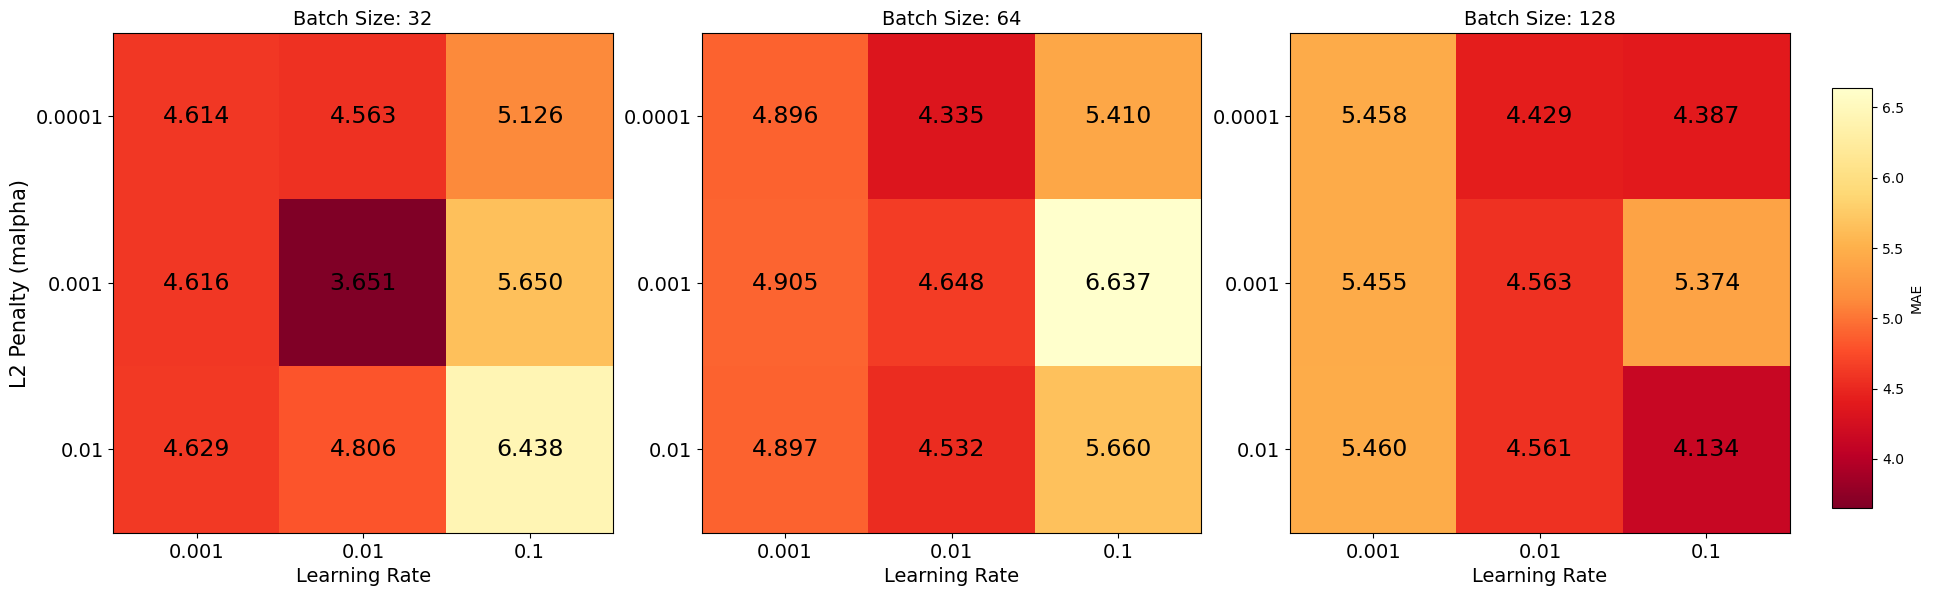

Best parameters: {'alpha': 0.001, 'learning_rate_init': 0.01, 'batch_size': 32}
Best test MAE: 3.6509601112713015


In [26]:
# Find the best combination
best_idx = np.unravel_index(np.argmin(mae_matrix_notscaled), mae_matrix_notscaled.shape)
best_params_notscaled = {
    'alpha': param_grid_notscaled['alpha'][best_idx[0]],
    'learning_rate_init': param_grid_notscaled['learning_rate_init'][best_idx[1]],
    'batch_size': param_grid_notscaled['batch_size'][best_idx[2]]
}
best_score_notscaled = mae_matrix_notscaled[best_idx]

# Plot the results
fig_notscaled, axes_notscaled = plt.subplots(1, 3, figsize=(20, 6))
batch_sizes_notscaled = [32, 64, 128]
# Find global min and max for consistent color scaling
value_min_notscaled = np.min(mae_matrix_notscaled)
value_max_notscaled = np.max(mae_matrix_notscaled)

for i, batch_size in enumerate(batch_sizes_notscaled):
    ax = axes_notscaled[i]
    im = ax.imshow(mae_matrix_notscaled[:, :, i], cmap='YlOrRd_r',
                   vmin=value_min_notscaled, vmax=value_max_notscaled)
    ax.set_xticks(np.arange(3))
    ax.set_yticks(np.arange(3))
    ax.set_xticklabels([0.001, 0.01, 0.1], fontsize=14)
    ax.set_yticklabels([0.0001, 0.001, 0.01], fontsize=14)
    ax.set_xlabel('Learning Rate', fontsize=14)
    if i == 0: ax.set_ylabel('L2 Penalty (malpha)', fontsize=15)
    ax.set_title(f'Batch Size: {batch_size}', fontsize=14)

    for j in range(3):
        for k in range(3):
            text = ax.text(k, j, f'{mae_matrix_notscaled[j, k, i]:.3f}',
                           ha="center", va="center", color="black",
                           fontsize=17)

plt.tight_layout()
fig_notscaled.subplots_adjust(right=0.9)

# Add a colorbar to the right of the subplots
cbar_ax = fig_notscaled.add_axes([0.92, 0.15, 0.02, 0.7])
fig_notscaled.colorbar(im, cax=cbar_ax, label='MAE')
plt.show()

print("Best parameters:", best_params_notscaled)
print("Best test MAE:", best_score_notscaled)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_netwo

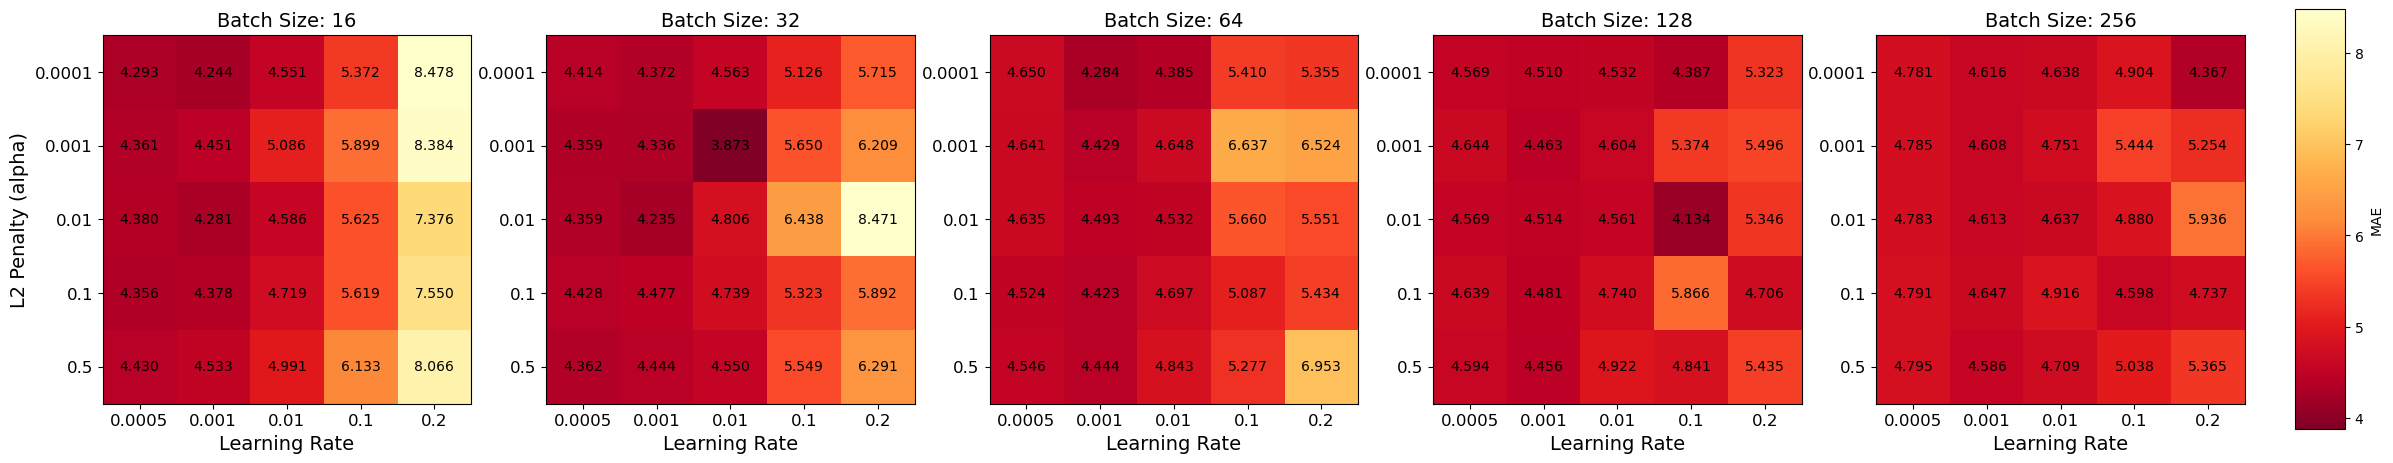

In [27]:

# Split the data
X_train, X_test, y_train, y_test = train_test_split(park_inp, park_tar, test_size=0.2, random_state=0)

# Define the model and parameter grid for Grid Search
param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 0.5],
    'learning_rate_init': [0.0005, 0.001, 0.01, 0.1, 0.2],
    'batch_size': [16,32, 64, 128, 256]
}
param_combinations = list(itertools.product(*param_grid.values()))

# Initialize matrix to store results
mae_matrix = np.zeros((5, 5, 5))

# Grid Search to find the best parameters
best_mae_gs = float('inf')
best_params_gs = None
for alpha, learning_rate, batch_size in param_combinations:
    model = MLPRegressor(hidden_layer_sizes=(10, 10), max_iter=1000, random_state=0,
                         alpha=alpha, learning_rate_init=learning_rate, batch_size=batch_size)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)

    idx_alpha = param_grid['alpha'].index(alpha)
    idx_lr = param_grid['learning_rate_init'].index(learning_rate)
    idx_batch = param_grid['batch_size'].index(batch_size)
    mae_matrix[idx_alpha, idx_lr, idx_batch] = mae

    if mae < best_mae_gs:
        best_mae_gs = mae
        best_params_gs = {'alpha': alpha, 'learning_rate_init': learning_rate, 'batch_size': batch_size}
# Plot the results
fig, axes = plt.subplots(1, 5, figsize=(25, 6))
batch_sizes = [16,32, 64, 128, 256]
value_min = np.min(mae_matrix)
value_max = np.max(mae_matrix)

for i, batch_size in enumerate(batch_sizes):
    ax = axes[i]
    im = ax.imshow(mae_matrix[:, :, i], cmap='YlOrRd_r', vmin=value_min, vmax=value_max)
    ax.set_xticks(np.arange(5))
    ax.set_yticks(np.arange(5))
    ax.set_xticklabels([0.0005, 0.001, 0.01, 0.1, 0.2], fontsize=12)
    ax.set_yticklabels([0.0001, 0.001, 0.01, 0.1, 0.5], fontsize=12)
    ax.set_xlabel('Learning Rate', fontsize=14)
    if i == 0: ax.set_ylabel('L2 Penalty (alpha)', fontsize=14)
    ax.set_title(f'Batch Size: {batch_size}', fontsize=14)

    for j in range(5):
        for k in range(5):
            ax.text(k, j, f'{mae_matrix[j, k, i]:.3f}', ha="center", va="center", color="black", fontsize=10)

plt.tight_layout()
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax, label='MAE')
plt.show()

Iteration 1: New  MAE = 4.6493 with params ['alpha': 0.0107, 'learning_rate_init': 0.0100, 'batch_size': 32]
current_mae =  3.8730950969770586
new_mae =  4.649263668036101
0.9075368828751134
Iteration 1: Best MAE = 4.6493 with params {'alpha': 0.010728717316630517, 'learning_rate_init': 0.01, 'batch_size': 32}
Iteration 2: New  MAE = 4.7118 with params ['alpha': 0.0101, 'learning_rate_init': 0.0774, 'batch_size': 32]
current_mae =  4.649263668036101
new_mae =  4.711794030680377
0.9918060754202311
Iteration 2: Best MAE = 4.6493 with params {'alpha': 0.010728717316630517, 'learning_rate_init': 0.01, 'batch_size': 32}
Iteration 3: New  MAE = 4.6832 with params ['alpha': 0.0018, 'learning_rate_init': 0.0071, 'batch_size': 32]
current_mae =  4.711794030680377
new_mae =  4.683153784171396
Iteration 3: Best MAE = 4.6493 with params {'alpha': 0.010728717316630517, 'learning_rate_init': 0.01, 'batch_size': 32}
Iteration 4: New  MAE = 4.5750 with params ['alpha': 0.0353, 'learning_rate_init': 0.

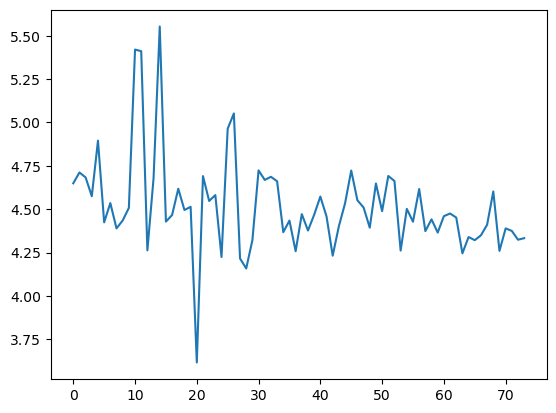

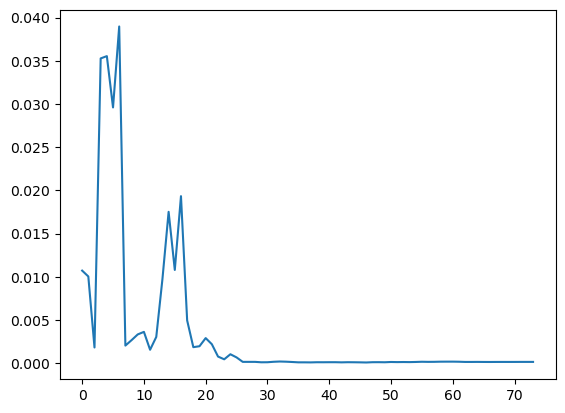

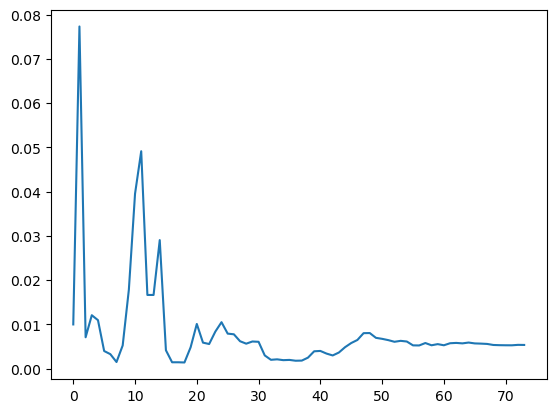

In [80]:
# Use the best parameters from Grid Search to initialize Simulated Annealing
initial_params = best_params_gs
param_bounds = {'alpha': [0.0001, 0.5], 'learning_rate_init': [0.001, 0.1], 'batch_size': [32, 256]}

random.seed(1)

# Simulated Annealing settings
n_iterations = 100
temperature = 8.0
cooling_rate = 0.95

def smooth_bound(x, lower, upper):
    """
    A function that smoothly approaches the bounds using a sigmoid-like function.
    It behaves linearly in the middle but smoothly saturates towards the bounds.
    """
    range_span = upper - lower
    return lower + (range_span / (1 + np.exp(-0.05 * (x - lower - 0.5 * range_span))))

# Helper function to generate a neighbour solution
def generate_neighbour(params, param_bounds,temperature):
    new_params = params.copy()

    # Generate new alpha value in log scale
    log_alpha = math.log10(params['alpha'])
    log_alpha_perturb = random.gauss(log_alpha,temperature/10)  # Adjust the stddev for perturbation size
    new_alpha = 10**log_alpha_perturb
    if param_bounds['alpha'][0] <= new_alpha <= param_bounds['alpha'][1]:
        new_params['alpha'] = new_alpha

    # Generate new learning_rate_init value in log scale
    log_learning_rate = math.log10(params['learning_rate_init'])
    log_learning_rate_perturb = random.gauss(log_learning_rate,temperature/10)  # Adjust the stddev for perturbation size
    new_learning_rate = 10**log_learning_rate_perturb
    if param_bounds['learning_rate_init'][0] <= new_learning_rate <= param_bounds['learning_rate_init'][1]:
        new_params['learning_rate_init'] = new_learning_rate

    return new_params

# Helper function to calculate acceptance probability
def acceptance_probability(old_mae, new_mae, temperature):
    if new_mae < old_mae:
        return 1.0
    else:
        acceptance_probability = np.exp((old_mae - new_mae) / temperature)
        print(acceptance_probability)
        return acceptance_probability

# Initialise with the best parameters from Grid Search
current_params = initial_params
model = MLPRegressor(hidden_layer_sizes=(10, 10), max_iter=1000, random_state=0,
                     alpha=current_params['alpha'],
                     learning_rate_init=current_params['learning_rate_init'],
                     batch_size=current_params['batch_size'])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
current_mae = mean_absolute_error(y_test, y_pred)

best_params = current_params
best_mae = current_mae

start_mae = 10
# Simulated Annealing loop
best_mae = start_mae
new_mae_list, alpha_list, learning_list, batch_list = [],[],[],[]

for iteration in range(n_iterations):
    if (iteration + 1) % 50 == 0:
        print("Best parameters found:", best_params)
        print("Best MAE:", best_mae)
        time.sleep(30)
    new_params = generate_neighbour(current_params,param_bounds,temperature)

    model = MLPRegressor(hidden_layer_sizes=(10, 10), max_iter=1000, random_state=0,
                         alpha=new_params['alpha'],
                         learning_rate_init=new_params['learning_rate_init'],
                         batch_size=32)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    new_mae = mean_absolute_error(y_test, y_pred)

    print(f"Iteration {iteration + 1}: New  MAE = {new_mae:.4f} with params ['alpha': {new_params['alpha']:.4f}, 'learning_rate_init': {new_params['learning_rate_init']:.4f}, 'batch_size': {new_params['batch_size']}]")
    print("current_mae = ", current_mae)
    print("new_mae = ", new_mae)
    if acceptance_probability(current_mae, new_mae, temperature) > random.random():
        current_params = new_params
        current_mae    = new_mae
        new_mae_list.append(new_mae)
        alpha_list.append(new_params['alpha'])
        learning_list.append(new_params['learning_rate_init'])
        batch_list.append(new_params['batch_size'])

    if new_mae < best_mae:
        best_params = new_params
        best_mae = new_mae

    temperature *= cooling_rate

    print(f"Iteration {iteration + 1}: Best MAE = {best_mae:.4f} with params {best_params}")

plt.figure()
plt.plot(new_mae_list)
plt.figure()
plt.plot(alpha_list)
plt.figure()
plt.plot(learning_list)
#plt.plot(batch_list)


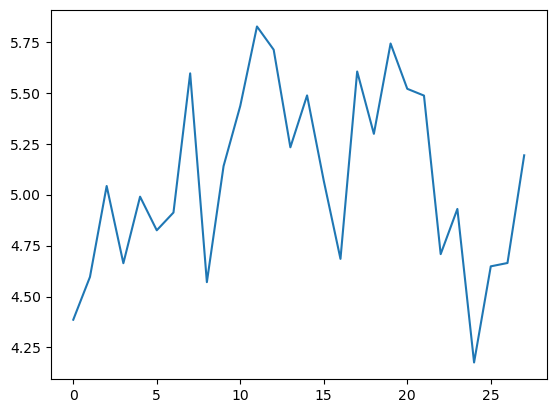

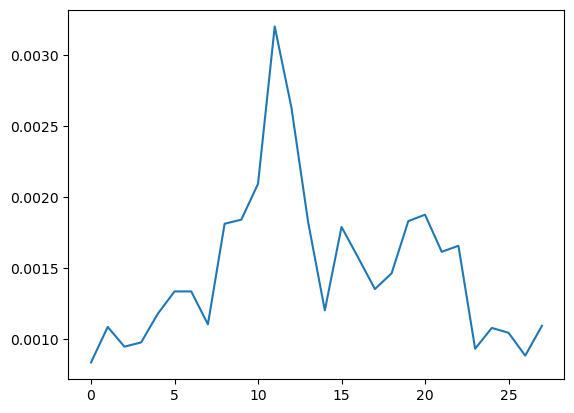

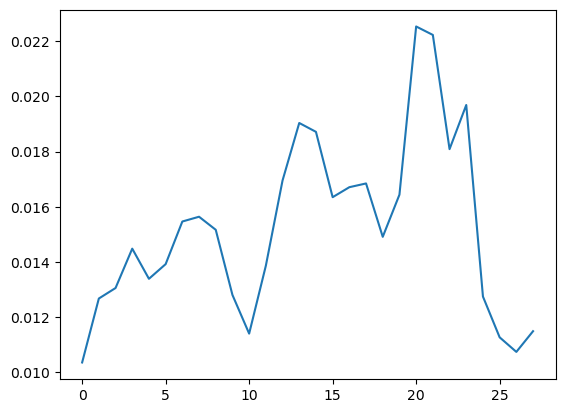

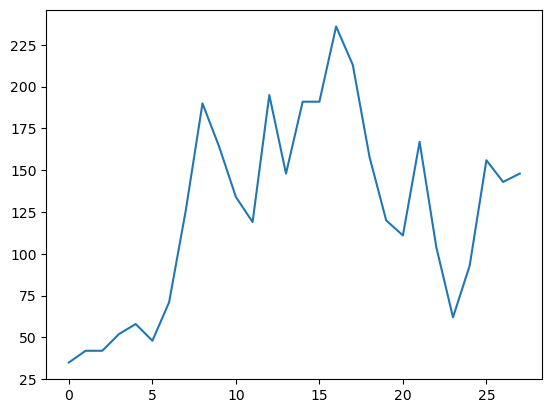

In [68]:
plt.figure(75)
plt.plot(new_mae_list)
plt.figure(76)
plt.plot(alpha_list)
plt.figure(77)
plt.plot(learning_list)
plt.figure(78)
plt.plot(batch_list)


Iteration: 1, MAE: 4.7827, Alpha: 0.0587, Learning Rate Init: 0.01, Batch Size: 32.0
Iteration: 2, MAE: 6.5414, Alpha: 0.1819, Learning Rate Init: 0.133, Batch Size: 32.0
Iteration: 3, MAE: 5.2419, Alpha: 0.2298, Learning Rate Init: 0.0737, Batch Size: 43.0
Iteration: 4, MAE: 5.6613, Alpha: 0.0525, Learning Rate Init: 0.1181, Batch Size: 51.0
Iteration: 5, MAE: 6.9147, Alpha: 0.2697, Learning Rate Init: 0.2043, Batch Size: 62.0
Iteration: 6, MAE: 6.2212, Alpha: 0.1444, Learning Rate Init: 0.2215, Batch Size: 58.0
Iteration: 7, MAE: 6.0618, Alpha: 0.1444, Learning Rate Init: 0.2215, Batch Size: 53.0
Iteration: 8, MAE: 6.0954, Alpha: 0.0216, Learning Rate Init: 0.2215, Batch Size: 45.0
Iteration: 9, MAE: 5.542, Alpha: 0.0216, Learning Rate Init: 0.1396, Batch Size: 44.0
Iteration: 10, MAE: 5.0691, Alpha: 0.1666, Learning Rate Init: 0.1234, Batch Size: 44.0
Iteration: 11, MAE: 5.7085, Alpha: 0.1666, Learning Rate Init: 0.1234, Batch Size: 38.0
Iteration: 12, MAE: 5.117, Alpha: 0.3189, Lea

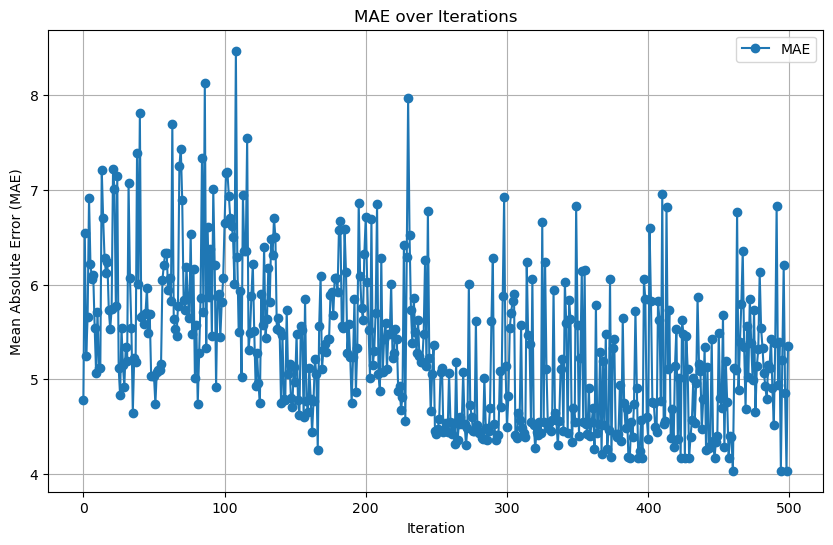

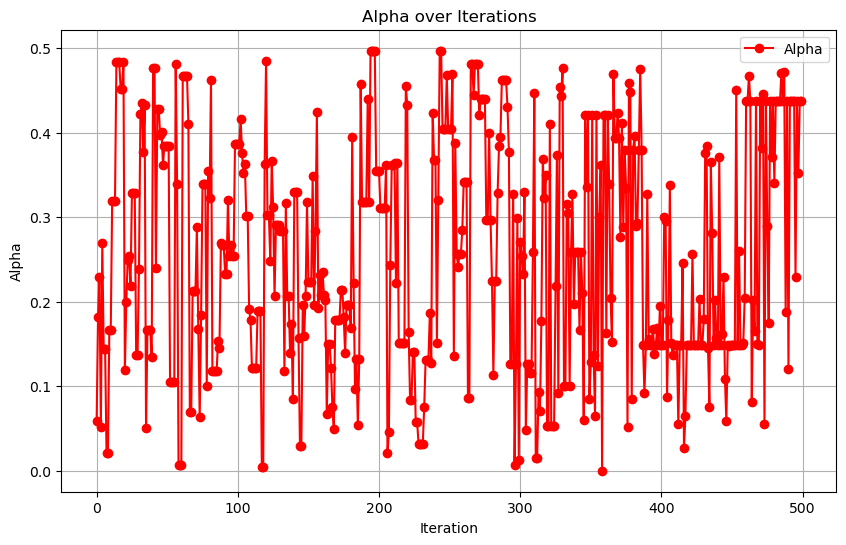

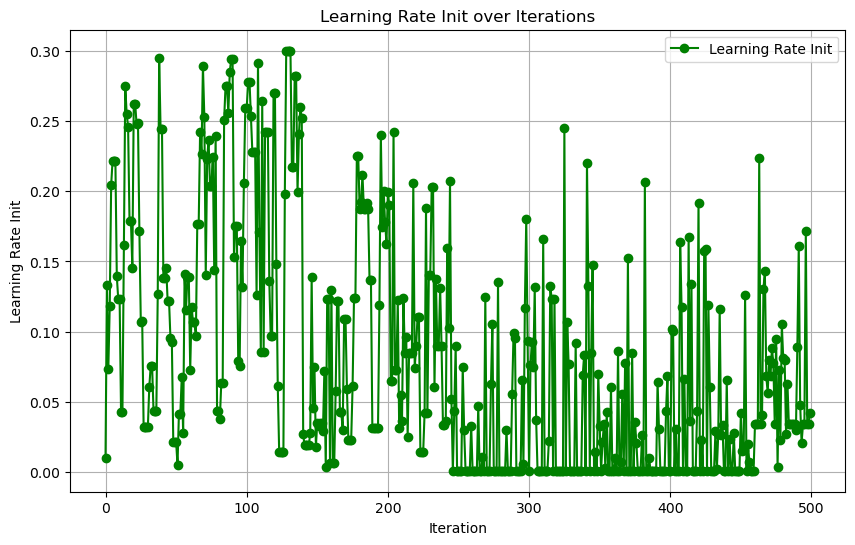

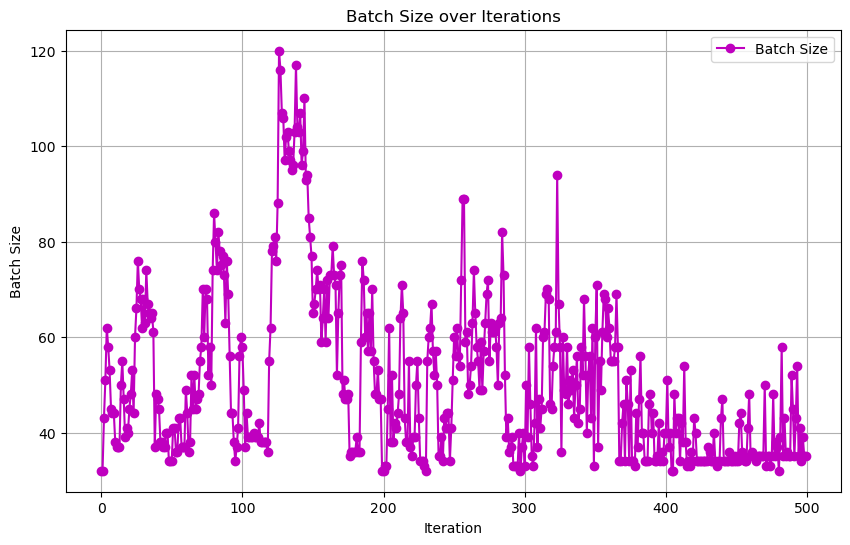

In [52]:
import re
import matplotlib.pyplot as plt

def parse_log_file(filename):
    # Regular expression pattern to match the desired lines
    pattern = r"Iteration (\d+): New. MAE = (\d.\d+) with params \['alpha': (\d.\d+), 'learning_rate_init': (\d.\d+), 'batch_size': (\d+)\]"
#Iteration 500: New  MAE = 5.3479 with params ['alpha': 0.4375, 'learning_rate_init': 0.0424, 'batch_size': 35]
    # List to store parsed results
    results = []

    # Open the log file and read line by line
    with open(filename, 'r') as file:
        for line in file:
            # Search for the pattern in the current line
            match = re.search(pattern, line)
            if match:
                iteration = int(match.group(1))
                mae = float(match.group(2))
                alpha = float(match.group(3))
                learning_rate_init = float(match.group(4))
                batch_size = float(match.group(5))

                # Append the parsed values to the results list
                results.append({
                    'iteration': iteration,
                    'mae': mae,
                    'alpha': alpha,
                    'learning_rate_init': learning_rate_init,
                    'batch_size': batch_size
                })

    return results

def plot_results(parsed_results):
    # Extract values for plotting
    iterations = [result['iteration'] for result in parsed_results]
    mae_values = [result['mae'] for result in parsed_results]
    alpha_values = [result['alpha'] for result in parsed_results]
    learning_rate_values = [result['learning_rate_init'] for result in parsed_results]
    batch_size_values = [result['batch_size'] for result in parsed_results]

    # Plot MAE over iterations
    plt.figure(figsize=(10, 6))
    plt.plot(mae_values, label='MAE', marker='o')
    plt.xlabel('Iteration')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.title('MAE over Iterations')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Alpha over iterations
    plt.figure(figsize=(10, 6))
    plt.plot(alpha_values, label='Alpha', marker='o', color='r')
    plt.xlabel('Iteration')
    plt.ylabel('Alpha')
    plt.title('Alpha over Iterations')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Learning Rate Init over iterations
    plt.figure(figsize=(10, 6))
    plt.plot(learning_rate_values, label='Learning Rate Init', marker='o', color='g')
    plt.xlabel('Iteration')
    plt.ylabel('Learning Rate Init')
    plt.title('Learning Rate Init over Iterations')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Batch Size over iterations
    plt.figure(figsize=(10, 6))
    plt.plot(batch_size_values, label='Batch Size', marker='o', color='m')
    plt.xlabel('Iteration')
    plt.ylabel('Batch Size')
    plt.title('Batch Size over Iterations')
    plt.legend()
    plt.grid(True)
    plt.show()

def main():
    # Parse the log file
    filename = "output.txt"  # Replace with your log file name
    parsed_results = parse_log_file(filename)

    # Display the parsed results
    for result in parsed_results:
        print(f"Iteration: {result['iteration']}, MAE: {result['mae']}, Alpha: {result['alpha']}, Learning Rate Init: {result['learning_rate_init']}, Batch Size: {result['batch_size']}")

    # Plot the parsed results
    plot_results(parsed_results)

if __name__ == "__main__":
    main()


In [62]:
current_mae_test = 5
for i in np.arange(5,10):
    acceptance_probability(current_mae, i , 1)

print(list(np.arange(5,10)))

0.7545257412609468
0.27757450804454536
0.10211395490286539
0.03756562466547198
0.013819621009189981
[5, 6, 7, 8, 9]


# 7) Scaled version

In [29]:
# Split the data
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(park_inp,park_tar,test_size=0.2,random_state=0)

# Scale the features
scaler_scaled = StandardScaler()
X_train_scaled = scaler_scaled.fit_transform(X_train_scaled)
X_test_scaled = scaler_scaled.fit_transform(X_test_scaled)

# Define the model and parameter grid
mlp_scaled = MLPRegressor(hidden_layer_sizes=(10, 10),
                   max_iter=1000, random_state=0)
param_grid_scaled = {
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'batch_size': [32, 64, 128]
}

# Generate all combinations of hyperparameters
param_combinations = list(itertools.product(*param_grid_scaled.values()))

# Initialize matrix to store results
mae_matrix_scaled = np.zeros((3, 3, 3))

# Iterate through all combinations
for i, (alpha, learning_rate, batch_size) in enumerate(param_combinations):
    # Create and train the model
    model = MLPRegressor(hidden_layer_sizes=(10, 10),
                         random_state=0,alpha=alpha,
                         learning_rate_init=learning_rate, batch_size=batch_size)
    model.fit(X_train_scaled, y_train_scaled)

    # Make predictions on the test set
    y_pred = model.predict(X_test_scaled)

    # Calculate MAE
    mae = mean_absolute_error(y_test_scaled, y_pred)

    # Store MAE in the matrix
    mae_matrix_scaled[
                param_grid_scaled['alpha'].index(alpha),
                param_grid_scaled['learning_rate_init'].index(learning_rate),
                param_grid_scaled['batch_size'].index(batch_size)] = mae

/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_

Plot the results and print the outcomes

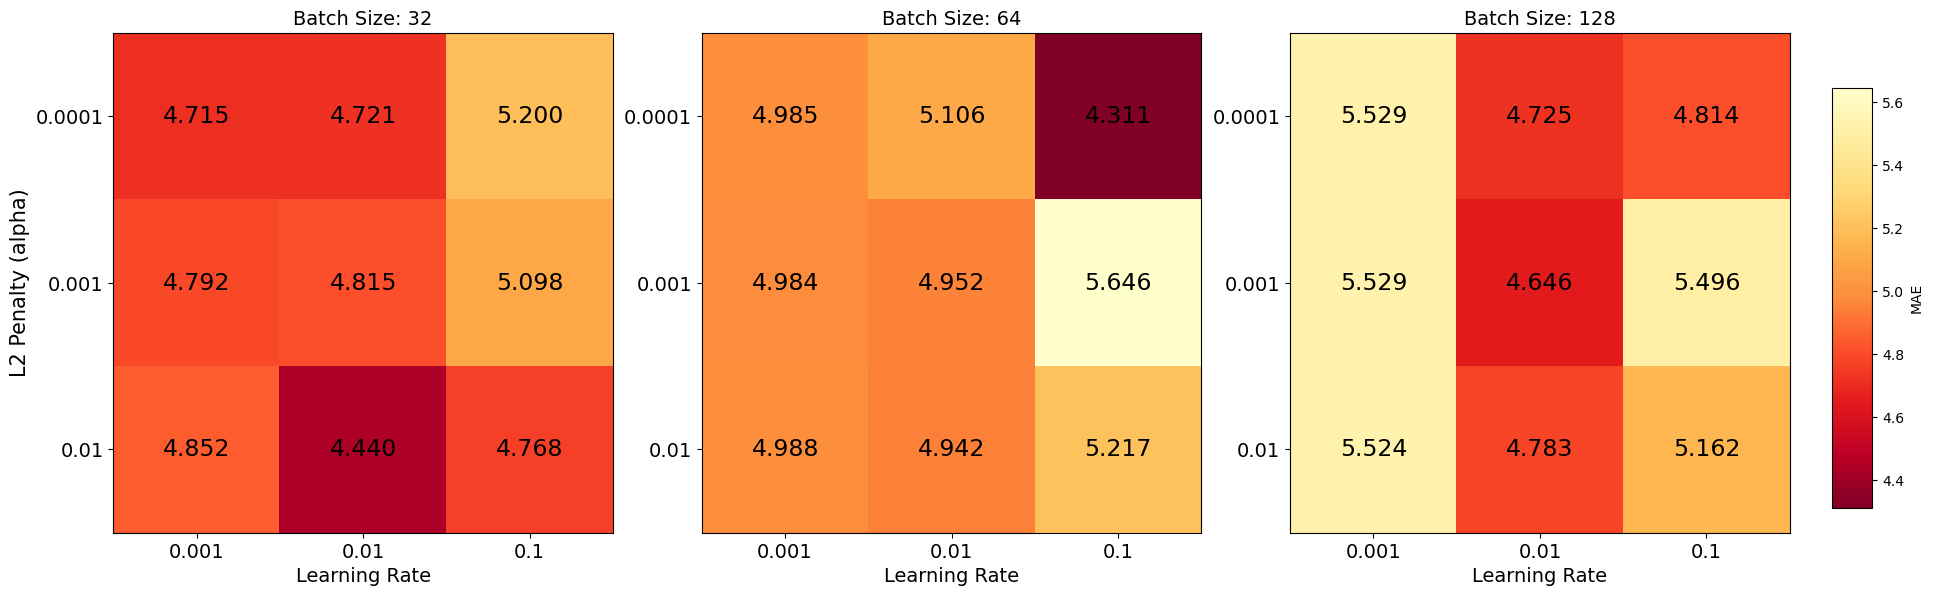

Best parameters: {'alpha': 0.0001, 'learning_rate_init': 0.1, 'batch_size': 64}
Best test MAE: 4.311155285323034


In [30]:
# Plot the results
fig_scaled, axes_scaled = plt.subplots(1, 3, figsize=(20, 6))
batch_sizes_scaled = [32, 64, 128]
# Find global min and max for consistent color scaling
value_min_scaled = np.min(mae_matrix_scaled)
value_max_scaled = np.max(mae_matrix_scaled)

for i, batch_size in enumerate(batch_sizes_scaled):
    ax = axes_scaled[i]
    im = ax.imshow(mae_matrix_scaled[:, :, i], cmap='YlOrRd_r',
                   vmin=value_min_scaled, vmax=value_max_scaled)
    ax.set_xticks(np.arange(3))
    ax.set_yticks(np.arange(3))
    ax.set_xticklabels([0.001, 0.01, 0.1], fontsize=14)
    ax.set_yticklabels([0.0001, 0.001, 0.01], fontsize=14)
    ax.set_xlabel('Learning Rate', fontsize=14)
    if i == 0: ax.set_ylabel('L2 Penalty (alpha)', fontsize=15)
    ax.set_title(f'Batch Size: {batch_size}', fontsize=14)

    for j in range(3):
        for k in range(3):
            text = ax.text(k, j, f'{mae_matrix_scaled[j, k, i]:.3f}',
                           ha="center", va="center", color="black",
                           fontsize=17)

plt.tight_layout()
fig_scaled.subplots_adjust(right=0.9)

# Add a colorbar to the right of the subplots
cbar_ax = fig_scaled.add_axes([0.92, 0.15, 0.02, 0.7])
fig_scaled.colorbar(im, cax=cbar_ax, label='MAE')
plt.show()

# Find the best combination
best_idx = np.unravel_index(np.argmin(mae_matrix_scaled), mae_matrix_scaled.shape)
best_params_scaled = {
    'alpha': param_grid_scaled['alpha'][best_idx[0]],
    'learning_rate_init': param_grid_scaled['learning_rate_init'][best_idx[1]],
    'batch_size': param_grid_scaled['batch_size'][best_idx[2]]
}
best_score_scaled = mae_matrix_scaled[best_idx]

print("Best parameters:", best_params_scaled)
print("Best test MAE:", best_score_scaled)

# Test the statistical significance of scaling the inputs beforehand

Paired t-test results:
t-statistic: 0.29043729908785404
p-value: 0.7737857363699637

Mean difference (Not Scaled - Scaled): -0.033521502304348215
Percentage of cases where scaled version performs better: 22.22%


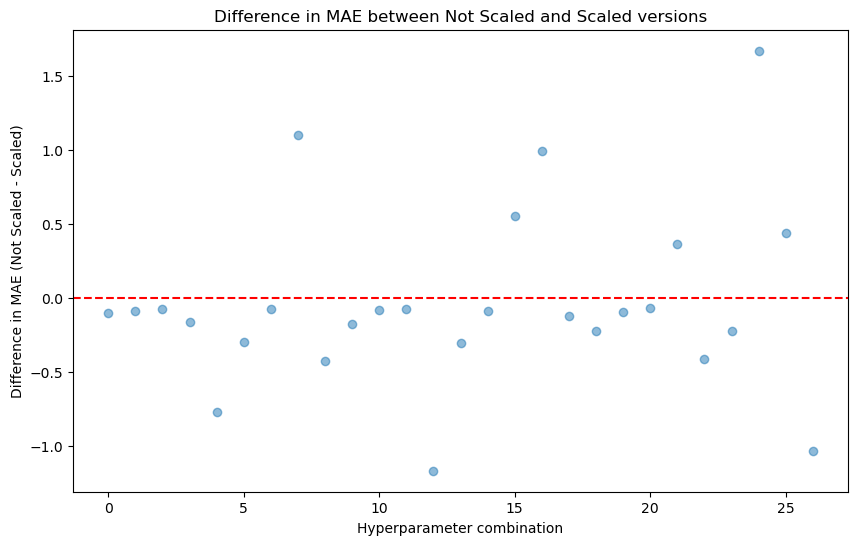

In [31]:
# Flatten the mae matrices
mae_scaled = mae_matrix_scaled.flatten()
mae_notscaled = mae_matrix_notscaled.flatten()

# Perform paired t-test
t_statistic, p_value = stats.ttest_rel(mae_scaled, mae_notscaled)

print(f"Paired t-test results:")
print(f"t-statistic: {t_statistic}")
print(f"p-value: {p_value}")

# Calculate mean difference
mean_difference = np.mean(mae_notscaled - mae_scaled)
print(f"\nMean difference (Not Scaled - Scaled): {mean_difference}")

# Calculate percentage of cases where scaled version performs better
scaled_better = np.sum(mae_scaled < mae_notscaled) / len(mae_scaled) * 100
print(f"Percentage of cases where scaled version performs better: {scaled_better:.2f}%")

# Visualize the differences
plt.figure(figsize=(10, 6))
plt.scatter(range(len(mae_scaled)), mae_notscaled - mae_scaled, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Hyperparameter combination")
plt.ylabel("Difference in MAE (Not Scaled - Scaled)")
plt.title("Difference in MAE between Not Scaled and Scaled versions")
plt.show()